In [5]:
%matplotlib inline

## Linear Models - [Bayes Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge)
- Allows you to use regularization parameters in the estimation procedure (they are tuned to the data, not "set" in a constant sense.)
- Done using [uninformed priors](https://en.wikipedia.org/wiki/Non-informative_prior#Uninformative_priors) on the model parameters.
- To obtain a fully probabilistic model, the output (y) is assumed to be a Gaussian distributed around $X w$:
    $p(y|X,w,\alpha) = \mathcal{N}(y|X w,\alpha)$
- Advantages: adapts to the data
- Disadvantages: model inference can be time-consuming.

## [Bayes Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge)
- Estimates a probabilistic model as shown above. 
- The prior for coefficient $w$ is a spherical Gaussian: $p(w|\lambda) =
\mathcal{N}(w|0,\lambda^{-1}\mathbf{I}_{p})$
- The priors for coefficients $\alpha$ & $\lambda$ are [gamma distributions](https://en.wikipedia.org/wiki/Gamma_distribution).
- All three coefficients are estimated during the model fit; the initial values can be set with ```alpha_init``` & ``` lambda_init```.

In [1]:
from sklearn import linear_model
X = [[0., 0.], [1., 1.], [2., 2.], [3., 3.]]
Y = [0., 1., 2., 3.]

reg = linear_model.BayesianRidge()
reg.fit(X, Y)

BayesianRidge()

In [2]:
# predicting new values using the fitted model
reg.predict([[1, 0.]])

array([0.50000013])

In [3]:
# accessing the coefficients
reg.coef_

array([0.49999993, 0.49999993])

## Example: Bayes Ridge regression on a synthetic dataset. 
- Plots predictions and uncertainties for BRR for a 1D regression using polynomial feature expansion.
- Note how uncertainty rises on the right side of the plot due to test samples being outside the training range samples.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import BayesianRidge, LinearRegression

In [6]:
# Generating simulated data with Gaussian weights
# Create weights with a precision lambda_ of 4.
# Only keep 10 weights of interest

np.random.seed(0)

n_samples, n_features = 100, 100
X                     = np.random.randn(n_samples, n_features)
lambda_               = 4.
w                     = np.zeros(n_features)
relevant_features     = np.random.randint(0, n_features, 10)

for i in relevant_features:
    w[i] = stats.norm.rvs(loc=0, scale=1. / np.sqrt(lambda_))

# Create noise with a precision alpha of 50.
alpha_ = 50.
noise = stats.norm.rvs(
    loc   = 0, 
    scale = 1. / np.sqrt(alpha_), 
    size  = n_samples)

y = np.dot(X, w) + noise

In [7]:
# Fit BRR and OLS for comparison
clf = BayesianRidge(compute_score=True)
ols = LinearRegression()

clf.fit(X, y)
ols.fit(X, y)

LinearRegression()

Text(0.5, 0, 'Iterations')

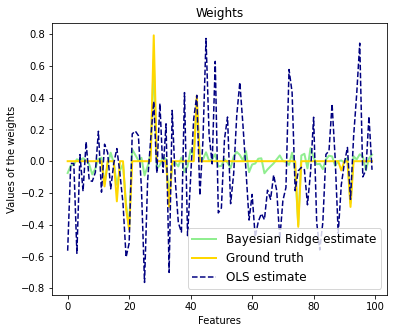

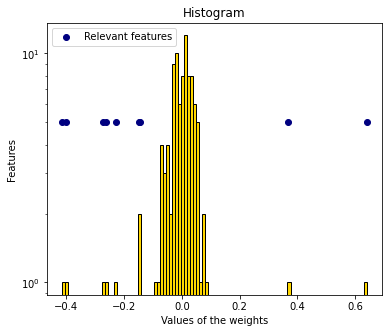

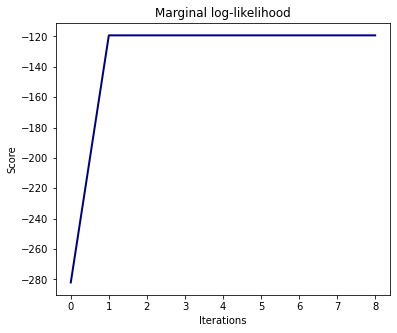

In [8]:
# Plot true weights, estimated weights, histogram of the weights, 
# and predictions with standard deviations
lw = 2

plt.figure(figsize=(6, 5))
plt.title("Weights")
plt.plot(clf.coef_, 
         color='lightgreen', linewidth=lw,
         label="Bayesian Ridge estimate")
plt.plot(w, 
         color='gold', linewidth=lw, 
         label="Ground truth")

plt.plot(ols.coef_, 
         color='navy', linestyle='--', 
         label="OLS estimate")

plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc="best", prop=dict(size=12))

plt.figure(figsize=(6, 5))
plt.title("Histogram")
plt.hist(clf.coef_, 
         bins=n_features, 
         color='gold', log=True,
         edgecolor='black')

plt.scatter(clf.coef_[relevant_features], 
            np.full(len(relevant_features), 5.),
            color='navy', 
            label="Relevant features")

plt.ylabel("Features")
plt.xlabel("Values of the weights")
plt.legend(loc="upper left")

plt.figure(figsize=(6, 5))
plt.title("Marginal log-likelihood")

plt.plot(clf.scores_, 
         color='navy', linewidth=lw)

plt.ylabel("Score")
plt.xlabel("Iterations")

In [9]:
# Plotting some predictions for polynomial regression
def f(x, noise_amount):
    y     = np.sqrt(x) * np.sin(x)
    noise = np.random.normal(0, 1, len(x))
    return y + noise_amount * noise

degree = 10
X      = np.linspace(0, 10, 100)
y      = f(X, noise_amount=0.1)

clf_poly = BayesianRidge()
clf_poly.fit(np.vander(X, degree), y)

X_plot = np.linspace(0, 11, 25)
y_plot = f(X_plot, noise_amount=0)
y_mean, y_std = clf_poly.predict(
    np.vander(X_plot, degree), 
    return_std=True)

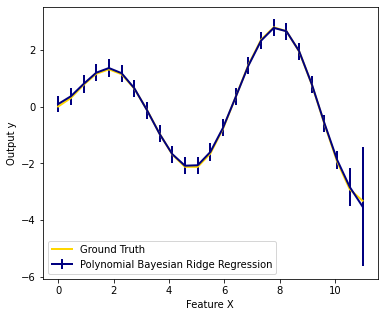

In [10]:
plt.figure(figsize=(6, 5))
plt.errorbar(X_plot, y_mean, y_std, color='navy',
             label="Polynomial Bayesian Ridge Regression", 
             linewidth=lw)

plt.plot(X_plot, y_plot, color='gold', linewidth=lw,
         label="Ground Truth")

plt.ylabel("Output y")
plt.xlabel("Feature X")
plt.legend(loc="lower left")
plt.show()

## Example: Sinusoidal Curve Fitting with BRR
- Sinusoid is approximated with a polynomial using different pairs of initial values.
- Defaults (alpha_init = 1.90, lambda_init = 1.0) return a large bias and small variance. So lambda_init should be relatively small (example: 1.0e-3) to reduce the bias.
- We can determine which is better using the log marginal likelihood of the models.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge

def func(x): return np.sin(2*np.pi*x)

In [12]:
# Generate sinusoidal data with noise
size    = 25
rng     = np.random.RandomState(1234)
x_train = rng.uniform(0., 1., size)
y_train = func(x_train) + rng.normal(scale=0.1, size=size)
x_test  = np.linspace(0., 1., 100)

In [13]:
# Fit by cubic polynomial (np.vander generates a Vandermonde matrix)
n_order = 3
X_train = np.vander(x_train, n_order + 1, increasing=True)
X_test  = np.vander(x_test,  n_order + 1, increasing=True)

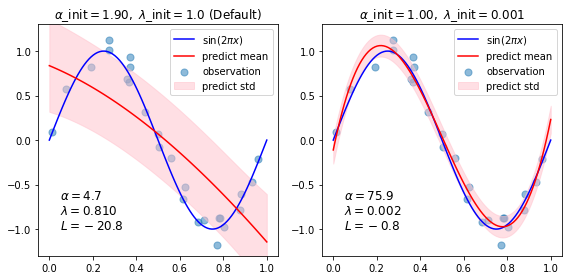

In [14]:
# Plot the true and predicted curves with log marginal likelihood (L)
reg = BayesianRidge(
    tol=1e-6, 
    fit_intercept=False, 
    compute_score=True)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for i, ax in enumerate(axes):
    # BRR with different initial value pairs
    if i == 0:
        init = [1 / np.var(y_train), 1.]  # Defaults
    elif i == 1:
        init = [1., 1e-3]
        reg.set_params(
            alpha_init  = init[0], 
            lambda_init = init[1])
        
    reg.fit(X_train, y_train)
    ymean, ystd = reg.predict(X_test, return_std=True)

    ax.plot(
        x_test, 
        func(x_test), 
        color="blue", 
        label="sin($2\\pi x$)")
    
    ax.scatter(
        x_train, 
        y_train, 
        s=50, 
        alpha=0.5, 
        label="observation")
    
    ax.plot(
        x_test, 
        ymean, 
        color="red", 
        label="predict mean")
    
    ax.fill_between(
        x_test, 
        ymean-ystd, 
        ymean+ystd,
        color="pink", 
        alpha=0.5, 
        label="predict std")
    
    ax.set_ylim(-1.3, 1.3)
    ax.legend()
    title = "$\\alpha$_init$={:.2f},\\ \\lambda$_init$={}$".format(
            init[0], init[1])
    
    if i == 0:
        title += " (Default)"
    ax.set_title(title, fontsize=12)
    text = "$\\alpha={:.1f}$\n$\\lambda={:.3f}$\n$L={:.1f}$".format(
           reg.alpha_, 
            reg.lambda_, 
            reg.scores_[-1])
    
    ax.text(0.05, -1.0, text, fontsize=12)

plt.tight_layout()
plt.show()

## [Auto Relevance Determination (ARD)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression)
- Similar to BRR but can return sparser coefficients. ARD assumes a distribution of $w$ to be an axis-parallel, elliptical Gaussian (Instead of a spherical Gaussian as in BRR.):
p(w|\lambda) = \mathcal{N}(w|0,A^{-1})
- Each coordinate $w_{i}$ has its own standard deviation $\lambda_i$; the prior over all $\gamma_{i}$ is the same gamma distribution given by $\lambda_1$ and $\lambda_2$.
- ARD is sometimes called _Sparse Bayesian Learning_ and _Reference Vector Machine_.

## Example: ARD, 1-D regression using polynomial feature expansion

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import ARDRegression, LinearRegression

In [16]:
# Generating simulated data with Gaussian weights
# Create weights with a precision lambda_ of 4.
# Only keep 10 weights of interest
# Create noise with a precision alpha of 50.

np.random.seed(0)
n_samples, n_features = 100, 100
X                     = np.random.randn(n_samples, n_features)
lambda_               = 4.
w                     = np.zeros(n_features)
relevant_features     = np.random.randint(0, n_features, 10)

for i in relevant_features:
    w[i] = stats.norm.rvs(loc=0, scale=1. / np.sqrt(lambda_))

alpha_ = 50.
noise  = stats.norm.rvs(loc   = 0, 
                        scale = 1. / np.sqrt(alpha_), 
                        size  = n_samples)
y      = np.dot(X, w) + noise

In [17]:
clf = ARDRegression(compute_score=True)
ols = LinearRegression()

clf.fit(X, y)
ols.fit(X, y)

LinearRegression()

Text(0.5, 0, 'Iterations')

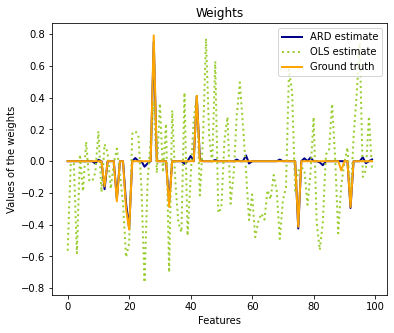

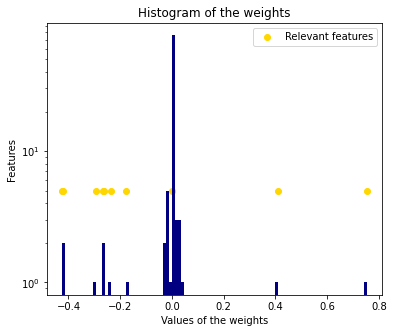

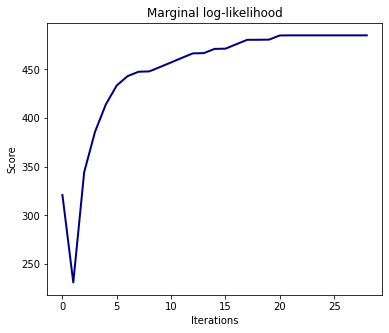

In [18]:
# plot true weights, est. weights, histogram of weights,
# predictions with std devs

plt.figure(figsize=(6, 5))
plt.title("Weights")
plt.plot(clf.coef_, 
         color='darkblue', linestyle='-', linewidth=2,
         label="ARD estimate")

plt.plot(ols.coef_, 
         color='yellowgreen', linestyle=':', linewidth=2,
         label="OLS estimate")

plt.plot(w, 
         color='orange', linestyle='-', linewidth=2, 
         label="Ground truth")

plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc=1)

plt.figure(figsize=(6, 5))
plt.title("Histogram of the weights")
plt.hist(clf.coef_, 
         bins=n_features, color='navy', log=True)

plt.scatter(clf.coef_[relevant_features], 
            np.full(len(relevant_features), 5.),
            color='gold', marker='o', 
            label="Relevant features")

plt.ylabel("Features")
plt.xlabel("Values of the weights")
plt.legend(loc=1)

plt.figure(figsize=(6, 5))
plt.title("Marginal log-likelihood")

plt.plot(clf.scores_, 
         color='navy', linewidth=2)

plt.ylabel("Score")
plt.xlabel("Iterations")

In [19]:
# Plotting some predictions for polynomial regression
def f(x, noise_amount):
    y     = np.sqrt(x) * np.sin(x)
    noise = np.random.normal(0, 1, len(x))
    return y + noise_amount * noise

In [20]:
degree = 10
X      = np.linspace(0, 10, 100)
y      = f(X, noise_amount=1)

clf_poly = ARDRegression(threshold_lambda=1e5)
clf_poly.fit(np.vander(X, degree), y)

ARDRegression(threshold_lambda=100000.0)

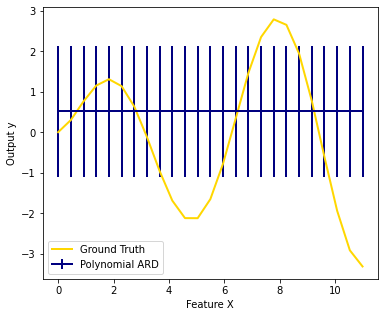

In [21]:
X_plot        = np.linspace(0, 11, 25)
y_plot        = f(X_plot, noise_amount=0)
y_mean, y_std = clf_poly.predict(
    np.vander(X_plot, degree), 
    return_std=True)

plt.figure(figsize=(6, 5))
plt.errorbar(X_plot, y_mean, y_std, 
             color='navy',
             label="Polynomial ARD", linewidth=2)

plt.plot(X_plot, y_plot, 
         color='gold', linewidth=2,
         label="Ground Truth")

plt.ylabel("Output y")
plt.xlabel("Feature X")
plt.legend(loc="lower left")
plt.show()